In [1]:
import os
import numpy as np

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'hmog_public_dataset/'

In [2]:
import pickle

test_file = open('hmog_dataset_ww_ws', 'rb')
session_hmog_matrices = pickle.load(test_file)
test_file.close()

In [3]:
# We need to exclude subjects who used landscape orientation
landscape_subjects = ['856302', '751131', '220962', '186676', '980953', '201848', '675397']
for l_s in landscape_subjects:
    del session_hmog_matrices[l_s]

subjects_list = list(session_hmog_matrices.keys())
print(f'len: {len(subjects_list)}\n\n{subjects_list}')

len: 92

['342329', '240168', '472761', '352716', '219303', '431312', '556357', '717868', '862649', '990622', '937904', '745224', '841866', '799296', '621276', '827212', '876011', '986737', '171538', '973891', '865881', '248252', '218719', '389015', '918136', '803262', '261313', '207969', '892687', '257279', '785873', '879155', '966655', '326223', '264325', '256487', '553321', '923862', '526319', '733568', '579284', '277905', '777078', '776328', '893255', '100669', '278135', '501973', '405035', '395129', '710707', '578526', '998757', '897652', '737973', '984799', '525584', '913228', '720193', '336172', '785899', '527796', '594887', '588087', '698266', '622852', '815316', '180679', '151985', '962159', '872895', '396697', '538363', '863985', '657486', '856401', '561993', '540641', '893198', '808022', '366286', '663153', '763813', '368258', '539502', '693572', '489146', '771782', '796581', '398248', '865501', '554303']


# Windowed Tests

## Single subject, same-session tests

In [8]:
WINDOW_SIZE = 40000  # ms
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

In [11]:
from sklearn.svm import OneClassSVM

# Windowed tests

for window_size in WINDOW_SIZES:
    true_pos_rate_sum = 0

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        session_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        # We scale all columns except for the 0th one (it's a timestamp)
        std_deviations, session_hmog_vector = HmogHelper.calc_std_and_scale(session_hmog_vector)
        session_hmog_vector_no_timestamp = np.delete(session_hmog_vector, 0, axis=1)

        # print(session_hmog_vector.shape)

        svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(session_hmog_vector_no_timestamp)
        true_pos_rate_sum += HmogHelper.test_hmog_windowed(session_hmog_vector, t_window=window_size, correct_key=1, model=svm)

    total_accuracy_windowed = true_pos_rate_sum / len(subjects_list)

    print(f'window size: {window_size / 1000}s.\nAccuracy windowed same-session tests: {total_accuracy_windowed}')
    

window size: 20.0s.
Accuracy windowed same-session tests: 0.9993125876063644
window size: 40.0s.
Accuracy windowed same-session tests: 1.0
window size: 60.0s.
Accuracy windowed same-session tests: 0.9995819397993312
window size: 80.0s.
Accuracy windowed same-session tests: 1.0
window size: 100.0s.
Accuracy windowed same-session tests: 1.0
window size: 120.0s.
Accuracy windowed same-session tests: 1.0
window size: 140.0s.
Accuracy windowed same-session tests: 1.0


## Single subject, different sessions tests

In [5]:
from sklearn.svm import OneClassSVM

for window_size in WINDOW_SIZES:

    true_pos_ratio_sum = 0
    count = len(subjects_list)

    for i in range(len(subjects_list)):
        subject = subjects_list[i]

        session_hmog_vector = np.vstack((session_hmog_matrices[subject][0], session_hmog_matrices[subject][1]))

        std_deviations, session_hmog_vector = HmogHelper.calc_std_and_scale(session_hmog_vector)
        session_hmog_vector_no_timestamp = np.delete(session_hmog_vector, 0, axis=1)

        test_hmog_vector = np.vstack((session_hmog_matrices[subject][2], session_hmog_matrices[subject][3]))
        test_hmog_vector = HmogHelper.scale_by(test_hmog_vector, std_deviations)

        if test_hmog_vector.shape[0] == 0:
            count -= 1
            continue

        svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(session_hmog_vector_no_timestamp)
        true_pos_ratio_sum += HmogHelper.test_hmog_windowed(test_hmog_vector, t_window=window_size, correct_key=1, model=svm)

    print(f'window size: {window_size / 1000}s.\nOut-of-session whole dataset average true positive ratio: {true_pos_ratio_sum / count}')

NameError: name 'OneClassSVM' is not defined

## Different subjects tests

In [32]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
from hmog.models import models

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

def test_eer(session_hmog_matrices, train_key: str, test_key: str, model_key: str, pos_val: int, neg_val: int):
    window_eers = {}

    for window_size in WINDOW_SIZES:
        eer_list = []

        for i in range(len(subjects_list)):
            subject = subjects_list[i]

            train_hmog_vector = np.vstack((session_hmog_matrices[subject][train_key][0], session_hmog_matrices[subject][train_key][1]))

            std_deviations, train_hmog_vector = HmogHelper.calc_std_and_scale(train_hmog_vector)
            train_hmog_vector_no_timestamp = np.delete(train_hmog_vector, 0, axis=1)

            # We use sessions belonging to the same subject for tests as well (but the sessions are different)
            test_hmog_vector_positive = np.vstack((session_hmog_matrices[subject][test_key][2], session_hmog_matrices[subject][test_key][3]))
            test_hmog_vector_positive = HmogHelper.scale_by(test_hmog_vector_positive, std_deviations)

            test_hmog_vector_negative = None
            
            if model_key == 'svm':
                model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01).fit(train_hmog_vector_no_timestamp)
            elif model_key == 'se':
                model = models.SEClassifier()
                model.fit(train_hmog_vector_no_timestamp)
            elif model_key == 'sm':
                model = models.SMClassifier()
                model.fit(train_hmog_vector_no_timestamp)

            other_subjects = subjects_list.copy()
            del other_subjects[i]

            for another_subject in other_subjects:
                test_hmog_vector_new = np.vstack((session_hmog_matrices[another_subject][test_key][2], session_hmog_matrices[another_subject][test_key][3]))

                if test_hmog_vector_new.shape[0] == 0:
                    continue

                if test_hmog_vector_negative is None:
                    test_hmog_vector_negative = test_hmog_vector_new
                else:
                    test_hmog_vector_negative = np.vstack((test_hmog_vector_negative, test_hmog_vector_new))

            # Now we need to scale the whole vector
            test_hmog_vector_negative = HmogHelper.scale_by(test_hmog_vector_negative, std_deviations)

            predictions_self = HmogHelper.test_hmog_windowed(test_hmog_vector_positive, t_window=window_size, model=model)
            y_true = [pos_val] * len(predictions_self)

            predictions_others = HmogHelper.test_hmog_windowed(test_hmog_vector_negative, t_window=window_size, model=model)
            y_true += ([neg_val] * len(predictions_others))

            scores = predictions_self + predictions_others

            fpr, tpr, thresholds = roc_curve(y_true, scores)

            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
            
            # Append EER to the list
            eer_list.append(eer)
        
        population_eer = np.mean(eer_list)
        window_eers[window_size] = population_eer
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')

    print('Done')
    return window_eers

In [33]:
svm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'svm', 1, -1)
svm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'svm', 1, -1)
svm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'svm', 1, -1)
svm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'svm', 1, -1)

Window size: 20.0s
Population EER: 0.1529992278868255
Window size: 40.0s
Population EER: 0.14460728159284708
Window size: 60.0s
Population EER: 0.1435655901751336
Window size: 80.0s
Population EER: 0.13708822997182254
Window size: 100.0s
Population EER: 0.12702076277349977
Window size: 120.0s
Population EER: 0.1406794888583894
Window size: 140.0s
Population EER: 0.13551386690688752
Done
Window size: 20.0s
Population EER: 0.2014964597986965
Window size: 40.0s
Population EER: 0.1950320185809405
Window size: 60.0s
Population EER: 0.19154996499177232
Window size: 80.0s
Population EER: 0.20448601279051726
Window size: 100.0s
Population EER: 0.1992023126540306
Window size: 120.0s
Population EER: 0.19811284799722637
Window size: 140.0s
Population EER: 0.2036956973417971
Done
Window size: 20.0s
Population EER: 0.34453138256122623
Window size: 40.0s
Population EER: 0.33907327441591223
Window size: 60.0s
Population EER: 0.32252960094698774
Window size: 80.0s
Population EER: 0.32480038354817414
W

In [34]:
se_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'se', 0, 1)
se_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'se', 0, 1)
se_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'se', 0, 1)
se_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'se', 0, 1)

Window size: 20.0s
Population EER: 0.16289019411261532
Window size: 40.0s
Population EER: 0.15649402470651072
Window size: 60.0s
Population EER: 0.13823614504029005
Window size: 80.0s
Population EER: 0.13271698574883556
Window size: 100.0s
Population EER: 0.13049591444977865
Window size: 120.0s
Population EER: 0.13546037919695883
Window size: 140.0s
Population EER: 0.135487345744236
Done
Window size: 20.0s
Population EER: 0.1814610687762304
Window size: 40.0s
Population EER: 0.17769647078760223
Window size: 60.0s
Population EER: 0.1759724715999561
Window size: 80.0s
Population EER: 0.1764946033901316
Window size: 100.0s
Population EER: 0.18243166530452845
Window size: 120.0s
Population EER: 0.17842844574995076
Window size: 140.0s
Population EER: 0.1957293578976763
Done
Window size: 20.0s
Population EER: 0.3287476421007876
Window size: 40.0s
Population EER: 0.3233063905130025
Window size: 60.0s
Population EER: 0.31623828510804275
Window size: 80.0s
Population EER: 0.30847105075579756
Wi

In [35]:
sm_ww_ww_eers = test_eer(session_hmog_matrices, 'w', 'w', 'sm', 0, 1)
sm_ws_ws_eers = test_eer(session_hmog_matrices, 's', 's', 'sm', 0, 1)
sm_ww_ws_eers = test_eer(session_hmog_matrices, 'w', 's', 'sm', 0, 1)
sm_ws_ww_eers = test_eer(session_hmog_matrices, 's', 'w', 'sm', 0, 1)

Window size: 20.0s
Population EER: 0.15035392149542434
Window size: 40.0s
Population EER: 0.12018275275090154
Window size: 60.0s
Population EER: 0.11223300931810712
Window size: 80.0s
Population EER: 0.10529697181317828
Window size: 100.0s
Population EER: 0.10309369983851503
Window size: 120.0s
Population EER: 0.10441135233119506
Window size: 140.0s
Population EER: 0.10393745426387771
Done
Window size: 20.0s
Population EER: 0.1532951821500744
Window size: 40.0s
Population EER: 0.13153961466119582
Window size: 60.0s
Population EER: 0.12639671471634828
Window size: 80.0s
Population EER: 0.13297869303733564
Window size: 100.0s
Population EER: 0.13386129315973508
Window size: 120.0s
Population EER: 0.1413557618287872
Window size: 140.0s
Population EER: 0.15915838211834057
Done
Window size: 20.0s
Population EER: 0.32751061096799067
Window size: 40.0s
Population EER: 0.31657120397566635
Window size: 60.0s
Population EER: 0.2967387339936173
Window size: 80.0s
Population EER: 0.286391565364556

# Data Pickling

In [38]:
import pickle
import os

def pickle_results(values: list, results_path: str, filename: str):
    abs_path = os.path.join(results_path, filename)
    if not os.path.exists(abs_path):
        result_file = open(abs_path, 'wb')
        pickle.dump(values, result_file)
        result_file.close()

In [39]:
pickle_results(list(svm_ww_ww_eers.values()), 'results/', 'svm_ww_ww_eers')
pickle_results(list(svm_ws_ws_eers.values()), 'results/', 'svm_ws_ws_eers')
pickle_results(list(svm_ww_ws_eers.values()), 'results/', 'svm_ww_ws_eers')
pickle_results(list(svm_ws_ww_eers.values()), 'results/', 'svm_ws_ww_eers')

pickle_results(list(se_ww_ww_eers.values()), 'results/', 'se_ww_ww_eers')
pickle_results(list(se_ws_ws_eers.values()), 'results/', 'se_ws_ws_eers')
pickle_results(list(se_ww_ws_eers.values()), 'results/', 'se_ww_ws_eers')
pickle_results(list(se_ws_ww_eers.values()), 'results/', 'se_ws_ww_eers')

pickle_results(list(sm_ww_ww_eers.values()), 'results/', 'sm_ww_ww_eers')
pickle_results(list(sm_ws_ws_eers.values()), 'results/', 'sm_ws_ws_eers')
pickle_results(list(sm_ww_ws_eers.values()), 'results/', 'sm_ww_ws_eers')
pickle_results(list(sm_ws_ww_eers.values()), 'results/', 'sm_ws_ww_eers')

# Visualisations

## Tables
Let's put all results into a table (window_size vs. sm/se/oneclasssvm)

In [5]:
# But firstly, let's load saved data since testing takes noticeable amount of time
import pickle
import os

def load_result(path_to_file: str):
    if os.path.exists(path_to_file):
        result_file = open(path_to_file, 'rb')
        result = pickle.load(result_file)
        result_file.close()

        return result
    return []

In [6]:
svm_ww_ww_eers = load_result('results/svm_ww_ww_eers')
svm_ws_ws_eers = load_result('results/svm_ws_ws_eers')
svm_ww_ws_eers = load_result('results/svm_ww_ws_eers')
svm_ws_ww_eers = load_result('results/svm_ws_ww_eers')

se_ww_ww_eers = load_result('results/se_ww_ww_eers')
se_ws_ws_eers = load_result('results/se_ws_ws_eers')
se_ww_ws_eers = load_result('results/se_ww_ws_eers')
se_ws_ww_eers = load_result('results/se_ws_ww_eers')

sm_ww_ww_eers = load_result('results/sm_ww_ww_eers')
sm_ws_ws_eers = load_result('results/sm_ws_ws_eers')
sm_ww_ws_eers = load_result('results/sm_ww_ws_eers')
sm_ws_ww_eers = load_result('results/sm_ws_ww_eers')

In [16]:
from tabulate import tabulate

windows_seconds = [size / 1000 for size in WINDOW_SIZES]
header = ['Model'] + [f'{window_s}s.' for window_s in windows_seconds]

table_ww_ww = [header,
              ['OneClassSVM'] + svm_ww_ww_eers,
              ['SE'] + se_ww_ww_eers,
              ['SM'] + sm_ww_ww_eers]

table_ws_ws = [header,
              ['OneClassSVM'] + svm_ws_ws_eers,
              ['SE'] + se_ws_ws_eers,
              ['SM'] + sm_ws_ws_eers]

table_ww_ws = [header,
              ['OneClassSVM'] + svm_ww_ws_eers,
              ['SE'] + se_ww_ws_eers,
              ['SM'] + sm_ww_ws_eers]

table_ws_ww = [header,
              ['OneClassSVM'] + svm_ws_ww_eers,
              ['SE'] + se_ws_ww_eers,
              ['SM'] + sm_ws_ww_eers]

print('walking + walking tests\n', tabulate(table_ww_ww, headers='firstrow'), end='\n\n')
print('sitting + sitting tests\n', tabulate(table_ws_ws, headers='firstrow'), end='\n\n')
print('walking + sitting tests\n', tabulate(table_ww_ws, headers='firstrow'), end='\n\n')
print('sitting + walking tests\n', tabulate(table_ws_ww, headers='firstrow'), end='\n\n')

walking + walking tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.152999  0.144607  0.143566  0.137088   0.127021   0.140679   0.135514
SE           0.16289   0.156494  0.138236  0.132717   0.130496   0.13546    0.135487
SM           0.150354  0.120183  0.112233  0.105297   0.103094   0.104411   0.103937

sitting + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.    140.0s.
-----------  --------  --------  --------  --------  ---------  ---------  ---------
OneClassSVM  0.201496  0.195032  0.19155   0.204486   0.199202   0.198113   0.203696
SE           0.181461  0.177696  0.175972  0.176495   0.182432   0.178428   0.195729
SM           0.153295  0.13154   0.126397  0.132979   0.133861   0.141356   0.159158

walking + sitting tests
 Model          20.0s.    40.0s.    60.0s.    80.0s.    100.0s.    120.0s.

## Plots

In [17]:
import matplotlib.pyplot as plt

def plot(data: list, xlabel: str, ylabel: str, title: str):
    y_lim_lower = 0
    y_lim_upper = 0.6

    for values, curve_label in data:
        plt.plot(windows_seconds, list(values), linestyle='dotted', label=curve_label)

    plt.ylim(y_lim_lower, y_lim_upper)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

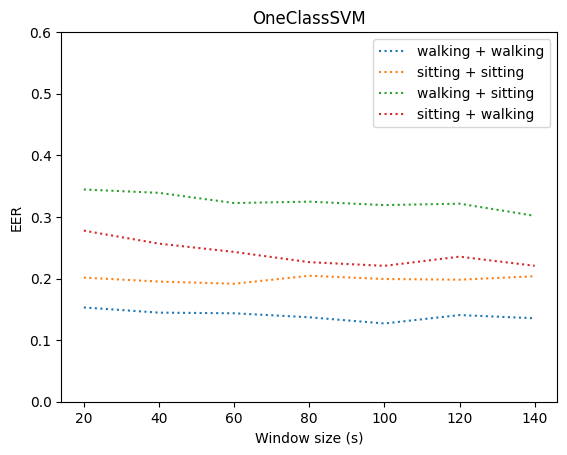

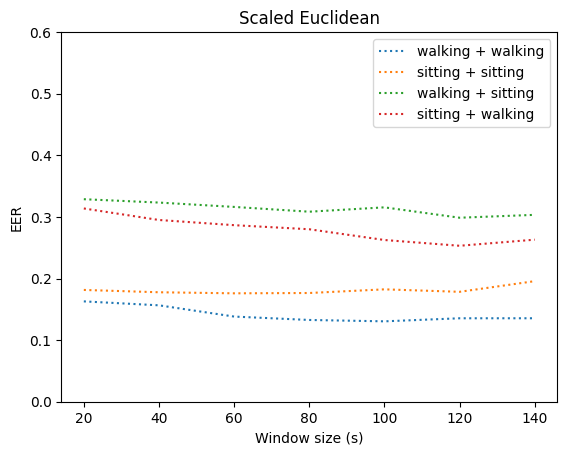

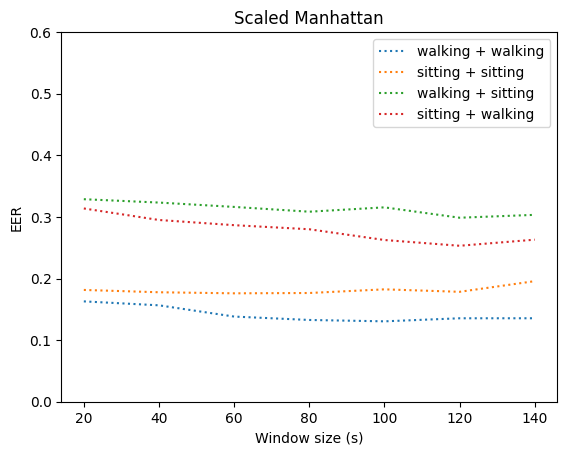

In [25]:
svm_all_data_comparison = [(svm_ww_ww_eers, 'walking + walking'),
                           (svm_ws_ws_eers, 'sitting + sitting'),
                           (svm_ww_ws_eers, 'walking + sitting'),
                           (svm_ws_ww_eers, 'sitting + walking')]

se_all_data_comparison = [(se_ww_ww_eers, 'walking + walking'),
                          (se_ws_ws_eers, 'sitting + sitting'),
                          (se_ww_ws_eers, 'walking + sitting'),
                          (se_ws_ww_eers, 'sitting + walking')]

sm_all_data_comparison = [(sm_ww_ww_eers, 'walking + walking'),
                          (sm_ws_ws_eers, 'sitting + sitting'),
                          (sm_ww_ws_eers, 'walking + sitting'),
                          (sm_ws_ww_eers, 'sitting + walking')]

plot(svm_all_data_comparison, 'Window size (s)', 'EER', 'OneClassSVM')
plot(se_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Euclidean')
plot(se_all_data_comparison, 'Window size (s)', 'EER', 'Scaled Manhattan')

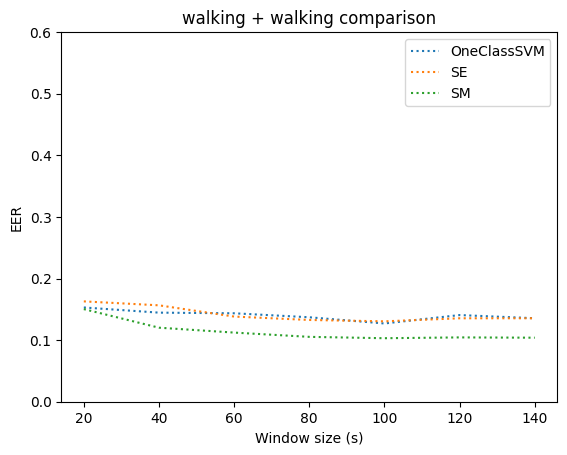

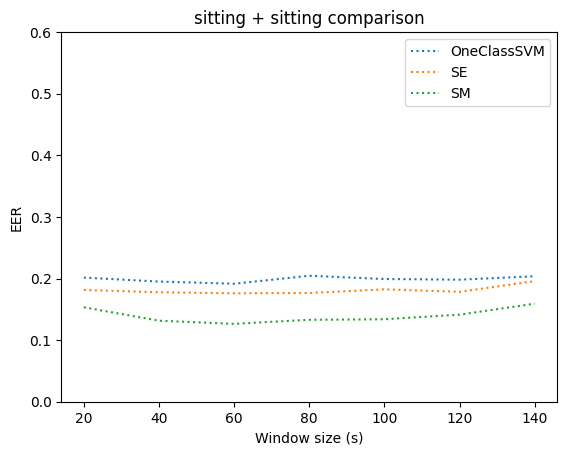

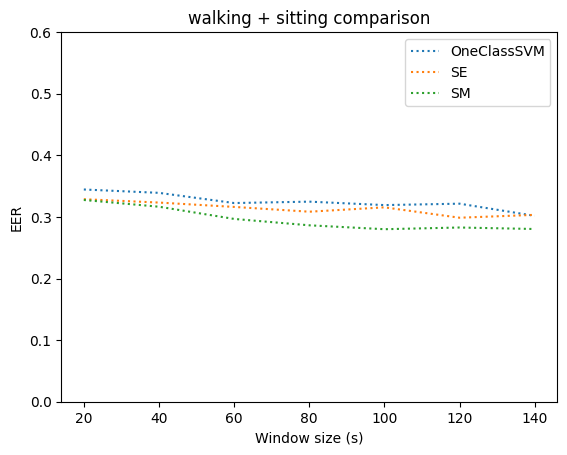

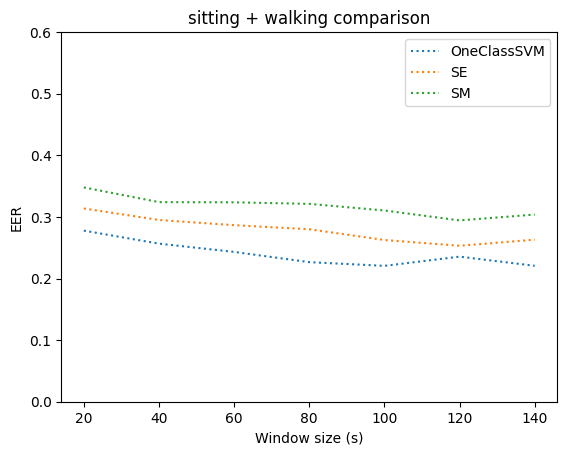

In [26]:
ww_ww_data_comparison = [(svm_ww_ww_eers, 'OneClassSVM'),
                      (se_ww_ww_eers, 'SE'),
                      (sm_ww_ww_eers, 'SM')]

ws_ws_data_comparison = [(svm_ws_ws_eers, 'OneClassSVM'),
                         (se_ws_ws_eers, 'SE'),
                         (sm_ws_ws_eers, 'SM')]

ww_ws_data_comparison = [(svm_ww_ws_eers, 'OneClassSVM'),
                         (se_ww_ws_eers, 'SE'),
                         (sm_ww_ws_eers, 'SM')]

ws_ww_data_comparison = [(svm_ws_ww_eers, 'OneClassSVM'),
                         (se_ws_ww_eers, 'SE'),
                         (sm_ws_ww_eers, 'SM')]

plot(ww_ww_data_comparison, 'Window size (s)', 'EER', 'walking + walking comparison')
plot(ws_ws_data_comparison, 'Window size (s)', 'EER', 'sitting + sitting comparison')
plot(ww_ws_data_comparison, 'Window size (s)', 'EER', 'walking + sitting comparison')
plot(ws_ww_data_comparison, 'Window size (s)', 'EER', 'sitting + walking comparison')